In [31]:
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable, Literal

from fairdivision.algorithms.envy_cycle_elimination import envy_cycle_elimination
from fairdivision.algorithms.draft_and_eliminate import draft_and_eliminate
from fairdivision.algorithms.ordered_picking import ordered_picking
from fairdivision.algorithms.round_robin import round_robin
from fairdivision.algorithms.xp_ece import xp_ece
from fairdivision.db.db_importer import get_instance, get_instances_with_discrete_allocations 
from fairdivision.utils.checkers import is_ef1, is_efx0, is_prop, is_ef

RANDOMIZED_ALGORITHMS = [
    ("XP-ECE", xp_ece)
]

DETERMINISTIC_ALGORITHMS = [
    ("Envy-Cycle Elimination", envy_cycle_elimination),
    ("Draft-and-Eliminate", draft_and_eliminate),
    ("Ordered Picking", ordered_picking),
    ("Round-Robin", lambda agents, items: round_robin(agents, items)[0])
]

In [98]:
def run_and_write(
    property_name: str,
    file_path: str,
    randomized_algorithms: list[tuple[str, Callable]] = RANDOMIZED_ALGORITHMS,
    deterministic_algorithms: list[tuple[str, Callable]] = DETERMINISTIC_ALGORITHMS, 
    randomized_iterations: int = 100,
    dataset: Literal["real"] | Literal["demo"] = "real") -> None:

    if property_name == "EF1":
        satisfies_property = lambda agents, _, allocation: is_ef1(agents, allocation) == True
    elif property_name == "EFX":
        satisfies_property = lambda agents, _, allocation: is_efx0(agents, allocation) == True
    elif property_name == "PROP":
        satisfies_property = lambda agents, items, allocation: is_prop(agents, items, allocation) == True
    elif property_name == "EF":
        satisfies_property = lambda agents, _, allocation: is_ef(agents, allocation) == True
    else:
        raise Exception(f"Property {property_name} is not supported")

    instances_ids = get_instances_with_discrete_allocations(dataset)
    
    satisfied_per_randomized_algorithm = dict()
    satisfied_per_deterministic_algorithm = dict()

    for algorithm_name, _ in randomized_algorithms:
        satisfied_per_randomized_algorithm[algorithm_name] = [0 for _ in range(randomized_iterations)]
    
    for algorithm_name, _ in deterministic_algorithms:
        satisfied_per_deterministic_algorithm[algorithm_name] = 0

    for instance_id in instances_ids:
        agents, items = get_instance(instance_id, dataset)

        for algorithm_name, algorithm in randomized_algorithms:
            for i in range(randomized_iterations):
                allocation = algorithm(agents, items)
        
                if satisfies_property(agents, items, allocation):
                    satisfied_per_randomized_algorithm[algorithm_name][i] += 1
    
        for algorithm_name, algorithm in deterministic_algorithms:
            allocation = algorithm(agents, items)
    
            if satisfies_property(agents, items, allocation):
                satisfied_per_deterministic_algorithm[algorithm_name] += 1

    with open(file_path, "w+") as file:
        for algorithm_name, _ in randomized_algorithms:
            satisfied_as_string = ",".join(map(lambda satisfied: str(satisfied), satisfied_per_randomized_algorithm[algorithm_name]))
            file.write(f"{algorithm_name},{satisfied_as_string}\n")

        for algorithm_name, _ in deterministic_algorithms:
            file.write(f"{algorithm_name},{satisfied_per_deterministic_algorithm[algorithm_name]}\n")


def read_and_draw(property_name: str, file_path: str, instances_number: int) -> None:
    with open(file_path, "r") as file:
        x = []
        y_values = []

        while True:
            line = file.readline()
            
            if len(line) == 0:
                break

            split_line = list(filter(lambda token: len(token) > 0, line.split(",")))

            x.append(split_line[0])
            y_values.append(list(map(lambda satisfied: int(satisfied), split_line[1:])))


        y = list(map(lambda satisfied_list: round(np.mean(satisfied_list)), y_values))

        plt.figure(figsize=(15, 6))
    
        plt.ylim(0, instances_number)
    
        plt.xlabel("Algorithm", fontsize=20)
        plt.ylabel(f"Number of {property_name} allocations", fontsize=20)

        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
    
        bar_color = ["#2184a5", "#f6c85f", "#6f4e7c", "#9dd866", "#ca472f"]
        text_on_bar_color = ["white", "black", "white", "black", "white"]
    
        plt.bar(x, y, color=bar_color, width=0.4)

        for i in range(len(x)):
            if len(y_values[i]) > 2:
                mean = np.mean(y_values[i])
                std = np.std(y_values[i])
        
                int_std = max(round(abs(round(mean) - (mean + std))), round(abs(round(mean) - (mean - std))))
        
                plt.errorbar(x[i], mean, yerr=int_std, capsize=4, color="black")
                plt.text(i, y[i] // 2, f"{y[i]} +/- {int_std}", ha='center', fontsize=14, color=text_on_bar_color[i])
            else:
                plt.text(i, y[i] // 2, str(y[i]), ha = 'center', fontsize=14, color=text_on_bar_color[i])
         
        plt.title(f"Number of {property_name} allocations per algorithm for Spliddit data", fontsize=24)
    
        plt.show()

## Running algorithms

### EF1

In [33]:
run_and_write("EF1", "data/comparison_spliddit_EF1.csv")

### EFX

In [34]:
run_and_write("EFX", "data/comparison_spliddit_EFX.csv")

### PROP

In [35]:
run_and_write("PROP", "data/comparison_spliddit_PROP.csv")

### EF

In [36]:
run_and_write("EF", "data/comparison_spliddit_EF.csv")

## Drawing charts

In [37]:
instances_number = len(get_instances_with_discrete_allocations("real"))

### EF1

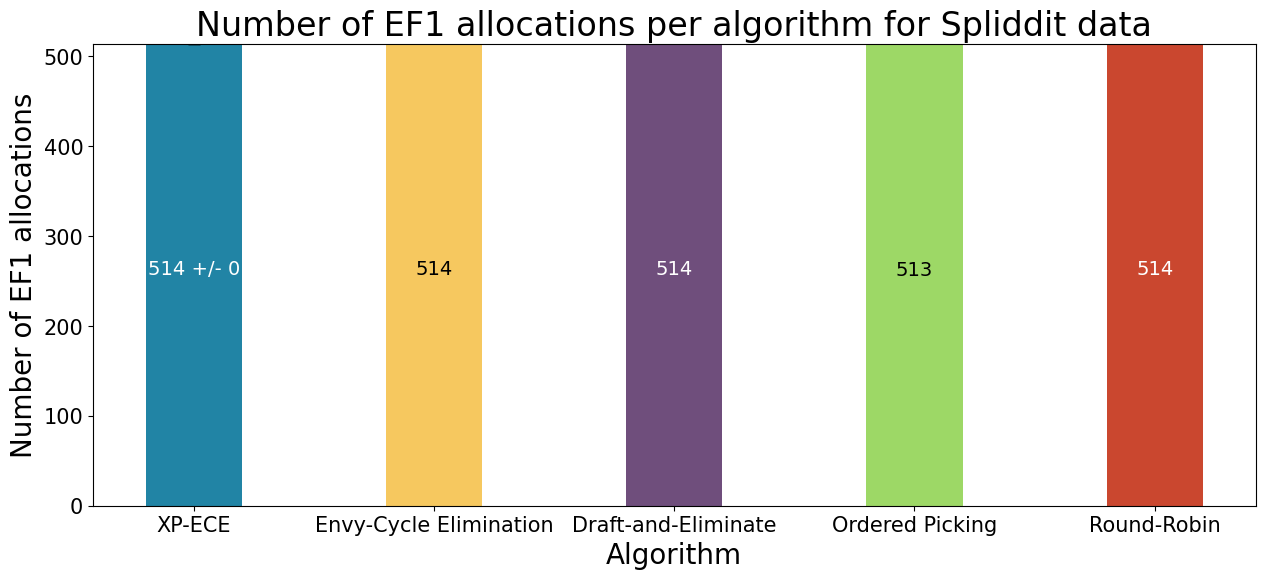

In [99]:
read_and_draw("EF1", "data/comparison_spliddit_EF1.csv", instances_number)

### EFX

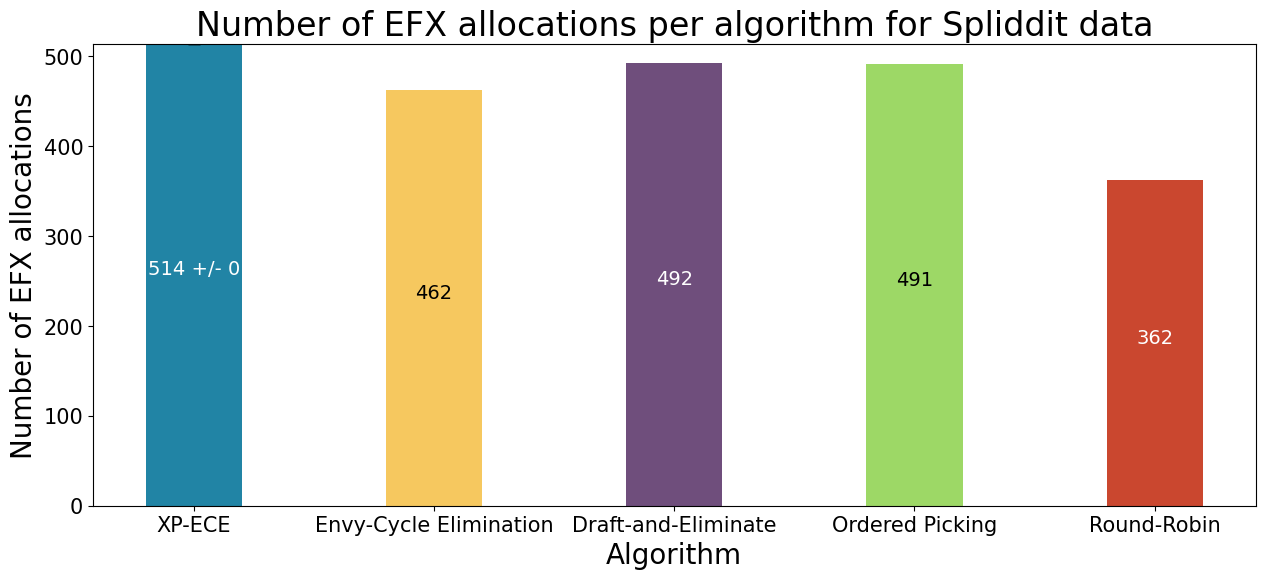

In [101]:
read_and_draw("EFX", "data/comparison_spliddit_EFX.csv", instances_number)

### PROP

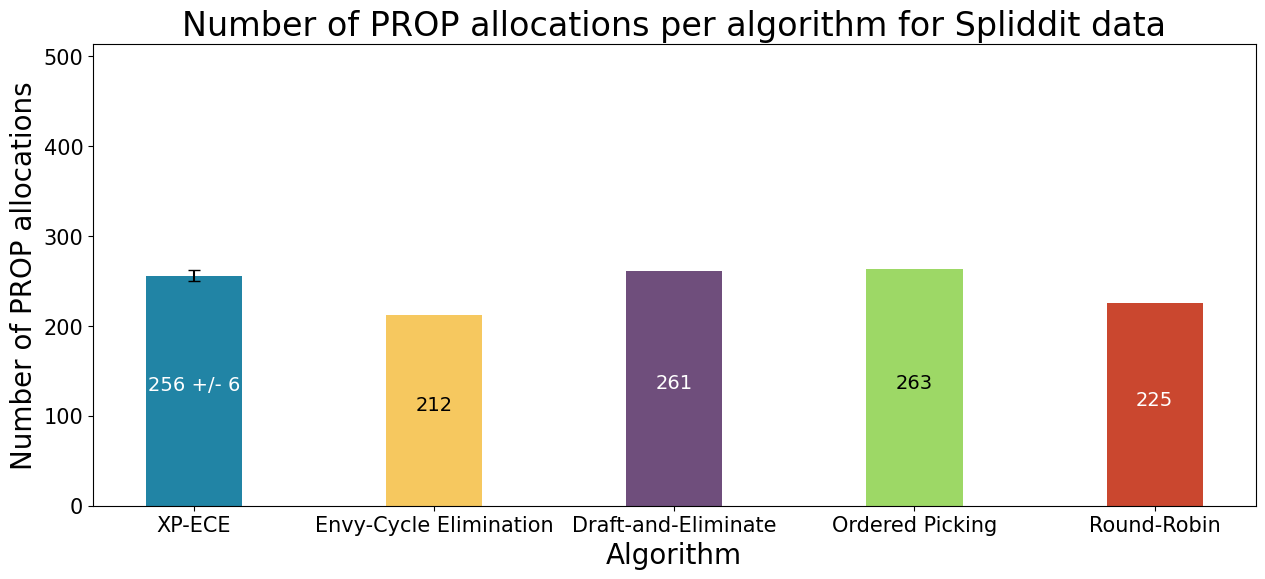

In [102]:
read_and_draw("PROP", "data/comparison_spliddit_PROP.csv", instances_number)

### EF

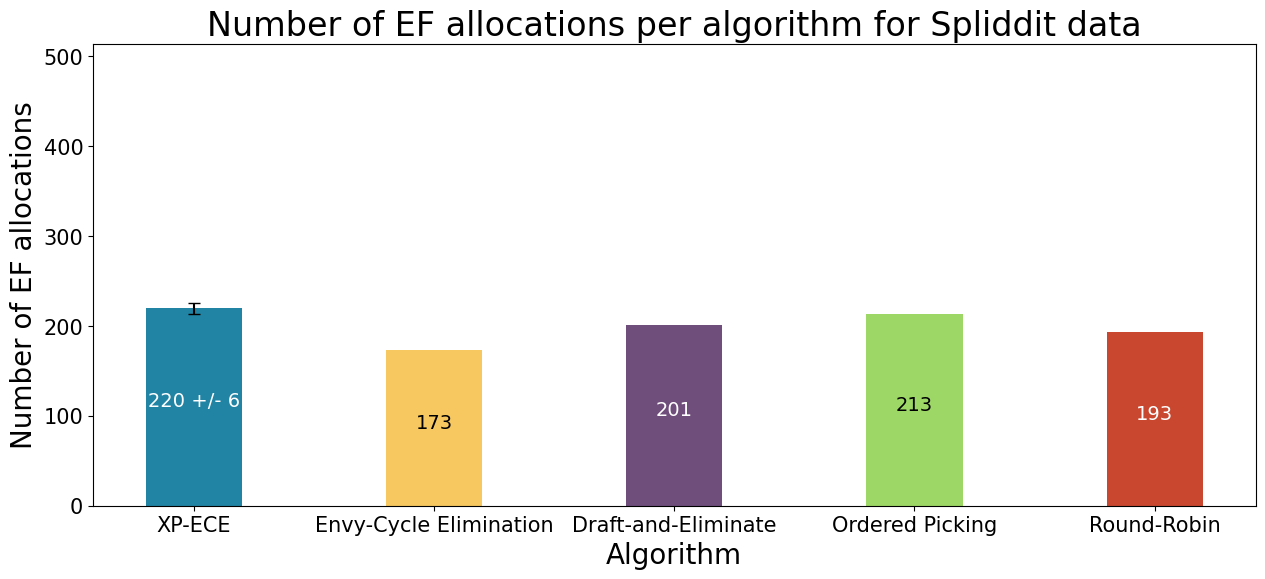

In [103]:
read_and_draw("EF", "data/comparison_spliddit_EF.csv", instances_number)